# Scania APS Diagnostics
by: [Kevin Atkinson](mailto:kmatk620@gmail.com)

## Business Understanding

Scania AB is a major Swedish manufacturer. We were founded in 1911. We have
production and assembly facilities in more than 15 countries in four
continents, including Europe, Asia, Africa and South America. We have over
50,000 employees and in 2022 we delivered over 85,000 vehicles with net sales
of over $16B USD.  

All Heavy Scania Trucks come with an APS, or Air Pressure System. The APS
produces high pressure air which is used in various critical functions such
as braking and gear shifting. While undergoing maintainence it's rare that
the APS needs to be repaired. Only 1 in 60 vehicles actually have a faulty APS.

Although it's inexpensive to inspect and repair the APS, the rarity of
failures in the system makes inspecting the APS of all trucks financially
untenebale. However, the cost of sending a vehicle back onto the road which
is soon to fail is approximately 50x more expensive than the inspection and
maintenance itself. Therefore we aim to use sensor data on the vehicle to
flag when the APS is in need of maintenance, with the overall goal of
minimizing repair cost.

In our case, false negatives cost \\$500, while false positives cost \\$10.

## Data Understanding

Our data is composed of sensor data drawn from 76,000 vehicles in 2016.
107 unique sensors are involved, totaling 170 columns, for a total of nearly
13,000,000 data points. Vehicles with faulty APS are very sparse, consisting
of less than 2% of the total vehicles in the data. This is a challenge for
accurate modeling. Due to the proprietary nature of the APS, sensor
information has been anonymized.

Our training data has ~850,000 null values, composing approximately 8% of all values.

## Data Preparation

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE

import xgboost
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [285]:
# import train and test data
aps_train = pd.read_csv('data/aps_training.csv')
aps_test = pd.read_csv('data/aps_test.csv')

In [65]:
aps.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 171 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   class   int64 
 1   aa_000  int64 
 2   ab_000  object
 3   ac_000  object
 4   ad_000  object
 5   ae_000  object
 6   af_000  object
 7   ag_000  object
 8   ag_001  object
 9   ag_002  object
 10  ag_003  object
 11  ag_004  object
 12  ag_005  object
 13  ag_006  object
 14  ag_007  object
 15  ag_008  object
 16  ag_009  object
 17  ah_000  object
 18  ai_000  object
 19  aj_000  object
 20  ak_000  object
 21  al_000  object
 22  am_0    object
 23  an_000  object
 24  ao_000  object
 25  ap_000  object
 26  aq_000  object
 27  ar_000  object
 28  as_000  object
 29  at_000  object
 30  au_000  object
 31  av_000  object
 32  ax_000  object
 33  ay_000  object
 34  ay_001  object
 35  ay_002  object
 36  ay_003  object
 37  ay_004  object
 38  ay_005  object
 39  ay_006  object
 40  ay_007  object
 41  ay_008  object
 42  ay_00

We see we have almost exclusively object columns. We'll need to convert these to numerics to be modeled.

In [66]:
aps_test['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

In [78]:
aps['ag_000'].value_counts()

0         59133
2             9
11912         5
16186         5
4             5
          ...  
193310        1
60334         1
246           1
2514          1
36            1
Name: ag_000, Length: 154, dtype: int64

Let's first get an idea of how many null values we have in total.

In [266]:
total_na = 0
for c in aps.columns:
    total_na += len(aps[c].loc[aps[c] == 'na'])
total_na

0

Our null values are currently formatted as strings of value 'na'. We'll need to convert these to np.nan in order to convert the datatypes of the columns to numerics.

Our target variables are currently strings of values 'pos' for positive class and 'neg' for negative class. We need to convert those to 1 for positive and 0 for negative.

In order to accomplish this we can create two functions. We can use these later in our Pipelines to streamline the process of running new data through our model.

In [292]:
# Function that takes a DataFrame as input, and outputs the same DataFrame but with nulls removed
def remove_na(df):
    df_copy = df.copy()
    for c in df_copy.columns:
        df_copy[c] = df_copy[c].map(lambda x: np.nan if x == 'na' else x)
    return df_copy

# Function that that takes a Series as input and converts 'pos' and 'neg' strings to 1s and 0s
def convert_posneg(series):
    return series.map(lambda x: 0 if x == 'neg' else 1)

Let's use our function to convert our target to binary values.

In [287]:
aps_train['class'] = convert_posneg(aps_train['class'])
aps_test['class'] = convert_posneg(aps_test['class'])

Now, let's convert these 'na' strings to np.nan.

In [293]:
aps_train = remove_na(aps_train)
aps_test = remove_na(aps_test)

In [77]:
aps['class'] = aps['class'].map(lambda x: 0 if x == 'neg' else 1)
aps_test['class'] = aps_test['class'].map(lambda x: 0 if x == 'neg' else 1)

In [80]:
# convert training nulls to np.nan
for c in aps.columns:
    aps[c] = aps[c].map(lambda x: np.nan if x == 'na' else x)

# convert test nulls to np.nan
for c in aps.columns:
    aps_test[c] = aps_test[c].map(lambda x: np.nan if x == 'na' else x)

Now that our nulls are formatted properly, let's get an idea of how they're distributed within our data by creating a histogram of total nulls within each row and column.

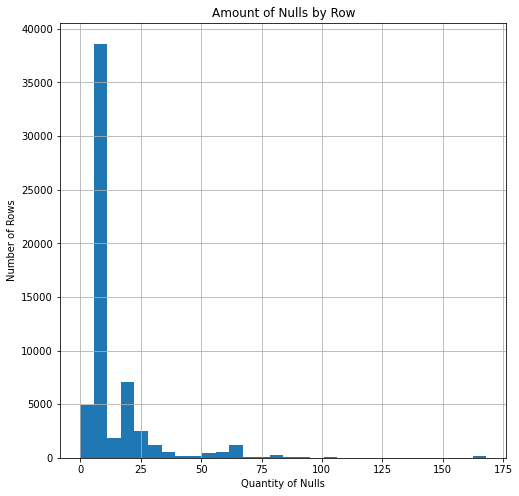

In [323]:
# na_in_rows = []
# for r in range(len(aps['class'])):
#     na_in_rows.append(aps.iloc[r].isna().sum())
ax = plt.axes()
ax.set_xlabel('Quantity of Nulls')
ax.set_ylabel('Number of Rows')
ax.set_title('Amount of Nulls by Row')
pd.Series(na_in_rows).hist(bins=30, figsize=(8,8));

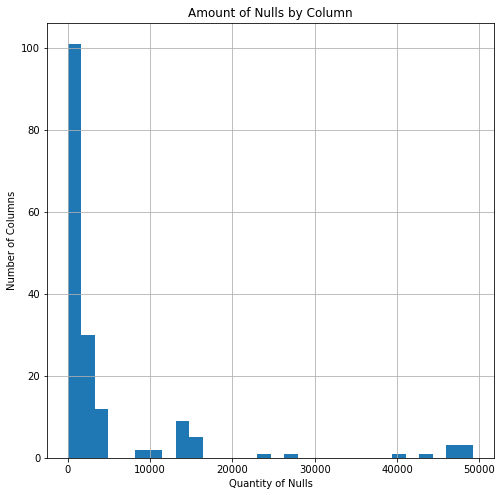

In [326]:
na_in_col = []
for c in aps.columns:
    na_in_col.append(aps[c].isna().sum())
ax = plt.axes()
ax.set_xlabel('Quantity of Nulls')
ax.set_ylabel('Number of Columns')
ax.set_title('Amount of Nulls by Column')
pd.Series(na_in_col).hist(bins=30, figsize=(8,8));

It's clear that most of our columns have little to no nulls. However, there are many rows with large amounts of null values. We could drastically reduce our null counts by dropping these rows. In practice, this won't make much sense. Each sample is data pulled from a vehicle undergoing maintenance. It's important that we can actually model the data drawn from any vehicle that enters our shop.

In the case of a vehicle whose APS sensors are outputting many null values, you might say we can just inspect their APS by default. This, however, is incorrect, as the pool of rows with many null values is much larger than the pool of our positive class. As a result, we most determine a method for modeling samples with many null values. 

To solve this problem we'll utilize a KNNImputer, or K-Nearest Neighbors Imputer. This imputer will fill in null values based on their proximity to other values in n-dimensional space.

We'll first split our target from our features prior to imputing nulls.

In [73]:
X_train = aps_train[aps_train.columns[1:]]
y_train = aps_train['class']
X_test = aps_test[aps_test.columns[1:]]
y_test = aps_test['class']

Now let's instantiate and use our KNNImputer.

In [ ]:
imputer = KNNImputer(n_neighbors=3)
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns= X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

This imputer takes a while to run, so let's save off this data to a CSV so we can load it back in without having to run the imputation whenever we open the notebook

In [ ]:
X_train_imp.to_csv('data/X_train_imp.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)

X_test_imp.to_csv('data/X_test_imp.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

And let's create the code to load in these CSVs back to DataFrames

In [81]:
X_train_imp = pd.read_csv('data/X_train_imp.csv')
y_train = pd.read_csv('data/y_train.csv')

X_test_imp = pd.read_csv('data/X_test_imp.csv')
y_test = pd.read_csv('data/y_test.csv')

Our data contains columns which represent binned histogram data. There are 7 of these histograms, comprising 10 columns each of our data.

Columns with historgram bins are:  
ag_000 - ag_009 (  7- 16)  
ay_000 - ay_009 ( 33- 42)  
az_000 - az_009 ( 43- 52)  
ba_000 - ba_009 ( 53- 62)  
cn_000 - cn_009 (100-109)  
cs_001 - cs_009 (114-123)  
ee_000 - ee_009 (159-168)  

For next steps, we could explore different ways of capturing the 'familiarity', for lack of a better term, these columns have with one another in order to improve the recall and precision of our model.

For the last step in our Data Preparation, let's scale the data.

In [82]:
scaler = StandardScaler()
X_train_imp_sc = scaler.fit_transform(X_train_imp)
X_test_imp_sc = scaler.transform(X_test_imp)

## Modeling

Since we know the cost of our Type I errors is \\$10, and the cost of our Type II errors is \\$500, we can create a custom scoring function order to evaluate the errors of our models in dollar amounts, and use that to minimize the total cost of our model.

### Custom cost function

In [165]:
def cost_loss(y, y_pred):
    cm = confusion_matrix(y, y_pred).ravel().tolist()
    return (cm[0]*0) + (cm[1]*10) + (cm[2]*500) + (cm[3]*0)

custom_cost = make_scorer(cost_loss, greater_is_better=False)

### Dummy Model

Let's start with a simple Dummy Model to establish a baseline.

In [137]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_imp_sc, y_train)
y_preds_dummy = dummy.predict(X_train_imp_sc)

In [138]:
recall_score(y_train, y_preds_dummy)

0.0

In [140]:
cost_loss(y_train, y_preds_dummy)

500000


500000

In [171]:
500000/60000

8.333333333333334

For a total of \\$8.33 per vehicle.

Let's try another Dummy Model, but this time predict Class 1 rather than Class 0.

In [141]:
dummy2 = DummyClassifier(strategy='constant', constant=1)
dummy2.fit(X_train_imp_sc, y_train)
y_preds_dummy2 = dummy2.predict(X_train_imp_sc)

In [142]:
recall_score(y_train, y_preds_dummy2)

1.0

In [143]:
cost_loss(y_train, y_preds_dummy2)

590000


590000

In [172]:
590000/60000

9.833333333333334

For a total of \\$9.83 per vehicle

### Logistic Regression

Now that we have our baseline, of which the results aren't stellar, we can attempt to beat it using our modeling techniques.

Let's try to beat our Dummy Model with a simple Logistic Regression.

In [144]:
logreg = LogisticRegression(random_state=2023, class_weight='balanced', max_iter=1000)

In [145]:
logreg.fit(X_train_imp_sc, y_train.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2023)

In [223]:
y_preds_logreg = logreg.predict(X_train_imp_sc)

In [166]:
cross_validate(logreg, X_train_imp_sc, y_train.values.ravel(), scoring='recall')['test_score'].mean()

0.906

In [224]:
recall_score(y_train, y_preds_logreg)

0.959

In [167]:
cross_validate(logreg, X_train_imp_sc, y_train.values.ravel(), scoring=custom_cost)['test_score'].mean() * -1

12402.0

In [225]:
cost_loss(y_train, y_preds_logreg)

35610

This equates to a total of \\$0.59 per vehicle. Much better than our Dummy Model, however, still overfit.

Note that although our model is overfit, our total cost is higher on our training set because there are more samples within it. Therefore this is not an apples to apples comparison. We can see a normalized cost by dividing each value by the number of vehicles within each set.

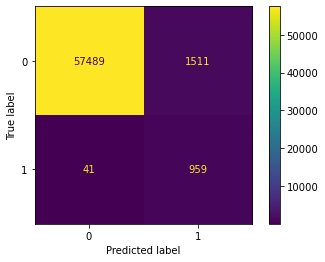

In [164]:
plot_confusion_matrix(logreg, X_train_imp_sc, y_train);

### Decision Tree

Now let's see if a Decision Tree will do a better job at classifying our data.

In [227]:
dt = DecisionTreeClassifier(random_state=2023)
dt.fit(X_train_imp_sc, y_train)

DecisionTreeClassifier(random_state=2023)

In [228]:
y_preds_dt = dt.predict(X_train_imp_sc)

In [229]:
cross_validate(dt, X_train_imp_sc, y_train.values.ravel(), scoring='recall')['test_score'].mean()

0.7230000000000001

In [230]:
recall_score(y_train, y_preds_dt)

1.0

In [231]:
cross_validate(dt, X_train_imp_sc, y_train.values.ravel(), scoring=custom_cost)['test_score'].mean() * -1

28336.0

In [232]:
cost_loss(y_train, y_preds_dt)

0

In [233]:
display(precision_score(y_train, y_preds_dt))
display(recall_score(y_train, y_preds_dt))
display(f1_score(y_train, y_preds_dt))

1.0

1.0

1.0

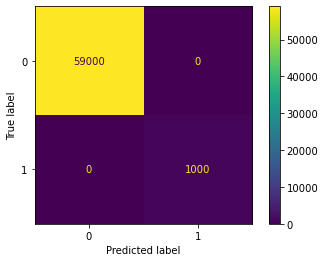

In [207]:
plot_confusion_matrix(dt, X_train_imp_sc, y_train);

As expected, this decision tree is extremely overfit on training data, but does quite poorly on cross validation. Let's see if we can modify the hyperparameters to get a model with better cross validation scores.

### Decision Tree with tuned hyperparameters

In [218]:
dt2 = DecisionTreeClassifier(random_state=2023, max_depth=6, class_weight='balanced')
dt2.fit(X_train_imp_sc, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=2023)

In [234]:
y_preds_dt2 = dt2.predict(X_train_imp_sc)

In [235]:
cross_validate(dt2, X_train_imp_sc, y_train.values.ravel(), scoring='recall')['test_score'].mean()

0.917

In [236]:
recall_score(y_train, y_preds_dt2)

0.983

In [237]:
cross_validate(dt2, X_train_imp_sc, y_train.values.ravel(), scoring=custom_cost)['test_score'].mean() * -1

13122.0

In [238]:
cost_loss(y_train, y_preds_dt2)

29710

In [241]:
display(precision_score(y_train, y_preds_dt2))
display(recall_score(y_train, y_preds_dt2))
display(f1_score(y_train, y_preds_dt2))

0.3166881443298969

0.983

0.47904483430799216

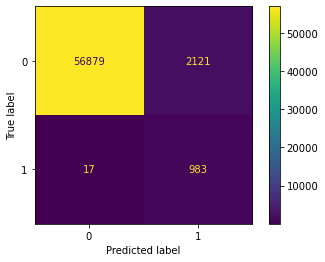

In [353]:
plot_confusion_matrix(dt2, X_train_imp_sc, y_train);

Our model is still quite overfit as compared to training data, however is doing much better in terms of cross validated recall and custom cost scores. So far, this seems to be our best model at predicting unseen data.

### SMOTE

Now let's attempt to account for the massive class imbalance by using SMOTE to generate snythetic data points in order to help our model better predict the minority class.

In [243]:
sm = SMOTE(random_state=2023, sampling_strategy=0.25)
X_train_imp_sc_sm, y_train_sm = sm.fit_resample(X_train_imp_sc, y_train)

In [259]:
logreg2 = LogisticRegression(random_state=42, max_iter=1000)
logreg2.fit(X_train_imp_sc_sm, y_train_sm.values.ravel())

LogisticRegression(max_iter=1000, random_state=42)

In [260]:
y_preds_logreg2 = logreg2.predict(X_train_imp_sc_sm)

In [250]:
cross_validate(logreg2, X_train_imp_sc_sm, y_train_sm.values.ravel(), scoring='recall')['test_score'].mean()

0.9025084745762711

In [261]:
recall_score(y_train_sm, y_preds_logreg2)

0.9046779661016949

In [255]:
cross_validate(logreg2, X_train_imp_sc_sm, y_train_sm.values.ravel(), scoring=custom_cost)['test_score'].mean() * -1

145228.0

In [262]:
cost_loss(y_train_sm, y_preds_logreg2)

709800

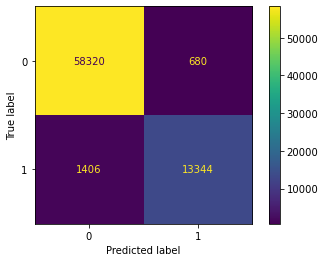

In [263]:
plot_confusion_matrix(logreg2, X_train_imp_sc_sm, y_train_sm);

This came out awful! SMOTEing this data was NOT effective!

### Random Forest

We're going to utilize our Grid Search to optimize this Random Forest with the hopes of creating the best model possible.

In [79]:
params = {}
params['criterion'] = ['gini', 'entropy']
params['max_depth'] = [None] + list(np.arange(1, 101, 10))
params['min_samples_split'] = np.arange(1, 21, 4)
params['max_features'] = ['sqrt', 'log2', None]

In [80]:
rfc = RandomForestClassifier()

In [81]:
gs = GridSearchCV(estimator=rfc, param_grid=params, cv=5, n_jobs=-1, verbose=3, scoring='recall')

In [82]:
# COMMENTED OUT TO AVOID RUNNING LONG CODE
# gs.fit(X_train_imp, y_train) 

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 117.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 222.4min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 282.1min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 336.9min
[Parallel(n_jobs=-1)]: Done 1650 out of 1650 | elapsed: 358.3min finished
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 11, 21, 31, 41, 51, 61, 71, 81,
                                       91],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': array([ 1,  5,  9, 13, 17])},
             scoring='recall', verbose=3)

In [83]:
gs.best_estimator_

RandomForestClassifier(max_depth=61, max_features=None, min_samples_split=5)

In [84]:
gs.best_score_

0.713

In [88]:
gs.cv_results_

{'mean_fit_time': array([2.00872564e-01, 5.01947179e+01, 4.95655776e+01, 4.91832494e+01,
        4.72163599e+01, 1.38519049e-01, 2.51734244e+01, 2.52650030e+01,
        2.58510067e+01, 2.70442314e+01, 1.46025419e-01, 9.12792709e+02,
        9.15803495e+02, 8.96173232e+02, 9.05937520e+02, 1.50028753e-01,
        3.44375820e+00, 3.51091609e+00, 3.45186534e+00, 3.82758808e+00,
        1.86560202e-01, 2.29367027e+00, 2.15044723e+00, 2.15304937e+00,
        2.18197417e+00, 1.40320206e-01, 3.66145526e+01, 3.64170828e+01,
        3.57845394e+01, 3.83230204e+01, 1.72047710e-01, 3.29758269e+01,
        3.15112685e+01, 3.03310548e+01, 3.10487715e+01, 1.54532719e-01,
        1.66087673e+01, 1.66335886e+01, 1.72479162e+01, 1.73435985e+01,
        1.35416222e-01, 3.93174545e+02, 4.02072763e+02, 3.93067954e+02,
        3.89381287e+02, 1.40921021e-01, 4.97720554e+01, 5.03727713e+01,
        5.02068290e+01, 5.03676668e+01, 1.79754353e-01, 2.57787444e+01,
        2.65564126e+01, 2.56486326e+01, 2.67267

In [299]:
y_preds_gs = gs.predict(X_train_imp_sc)

In [250]:
cross_validate(gs, X_train_imp_sc, y_train.values.ravel(), scoring='recall')['test_score'].mean()

0.9025084745762711

In [327]:
recall_score(y_train, y_preds_gs)

0.993

In [255]:
cross_validate(gs, X_train_imp_sc, y_train.values.ravel(), scoring=custom_cost)['test_score'].mean() * -1

145228.0

In [329]:
cost_loss(y_train, y_preds_gs)

3510

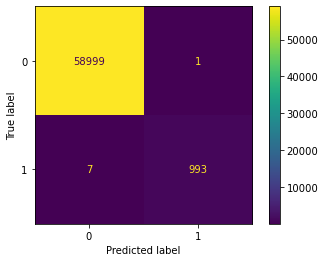

In [300]:
plot_confusion_matrix(gs, X_train_imp_sc, y_train);

Although the results of our first Grid Search were sub-par, let's try to narrow down the range of our hyperparameters in order to hopefully achieve greater success.

## Grid Search Attempt #2

In [121]:
params2 = {}
params2['max_depth'] = [60, 61, 62]
params2['max_features'] = [None]
params2['min_samples_split'] = [4, 5, 6]

In [122]:
gs2 = GridSearchCV(estimator=rfc2, param_grid=params2, cv=5, n_jobs=-2, verbose=3, scoring=cost_scorer)

In [123]:
# COMMENTED OUT TO AVOID RUNNING LONG CODE
# gs2.fit(X_train_imp, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-2)]: Done  40 out of  45 | elapsed: 55.0min remaining:  6.9min
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed: 64.7min finished
C:\Users\Kevin\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=61, max_features=None,
                                              min_samples_split=5),
             n_jobs=-2,
             param_grid={'max_depth': [60, 61, 62], 'max_features': [None],
                         'min_samples_split': [4, 5, 6]},
             scoring=make_scorer(cost_loss, greater_is_better=False),
             verbose=3)

In [145]:
gs2.best_estimator_

RandomForestClassifier(max_depth=62, max_features=None, min_samples_split=4)

In [146]:
gs2.cv_results_

{'mean_fit_time': array([844.86455655, 839.23752279, 834.2154089 , 820.51233773,
        818.44175911, 814.89210958, 807.33571863, 801.52022314,
        769.75853934]),
 'std_fit_time': array([12.15444579, 20.48218122, 15.24897677, 16.3645281 , 15.99797453,
         8.31353987, 14.72638123, 16.79923248, 67.57428524]),
 'mean_score_time': array([0.15123   , 0.15393229, 0.15153017, 0.15443263, 0.1520308 ,
        0.14832745, 0.14462428, 0.13191328, 0.10589099]),
 'std_score_time': array([0.00177366, 0.00505017, 0.0041192 , 0.00650628, 0.00759845,
        0.00652187, 0.00279517, 0.01502822, 0.00353278]),
 'param_max_depth': masked_array(data=[60, 60, 60, 61, 61, 61, 62, 62, 62],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[None, None, None, None, None, None, None, None, None],
              mask=[False, False, False, False, False, False, 

In [126]:
gs2.best_score_

-28598.0

In [141]:
y_preds_gs2 = gs2.predict(X_train_imp)

In [142]:
confusion_matrix(y_train, y_preds_gs2)

array([[59000,     0],
       [    4,   996]], dtype=int64)

In [143]:
cost_loss(y_train, y_preds_gs2)

2000

It seems that for whatever reason, our data is not well-predicted using Decision Trees or Random Forests. To take a different approach, let's attempt to use XGBoost in order to hopefully beat our original Logistic Regression.

## XGBoost

In [331]:
gboost = xgboost.XGBClassifier(tree_method='gpu_hist')

In [332]:
gboost.fit(X_train_imp_sc, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [333]:
xgb_preds = gboost.predict(X_train_imp_sc)

In [334]:
cost_loss(y_train, xgb_preds)

0

In [338]:
cross_validate(gboost, X_train_imp_sc, y_train.values.ravel(), scoring='recall')['test_score'].mean()

0.752

In [339]:
recall_score(y_train, xgb_preds)

1.0

In [340]:
cross_validate(gboost, X_train_imp_sc, y_train.values.ravel(), scoring=custom_cost)['test_score'].mean() * -1

24966.0

In [342]:
cost_loss(y_train, xgb_preds)

0

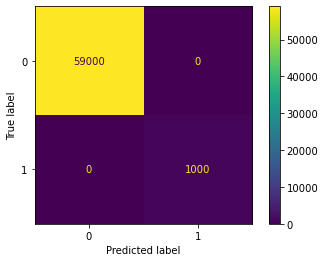

In [335]:
plot_confusion_matrix(gboost, X_train_imp_sc, y_train);

## XGBoost with Grid Search

We can see that we are yet again greatly overfit. Perhaps using a Grid Search with XGBoost will enable us to find the sweet spot of under/overfitting.

In [330]:
xgb = xgboost.XGBClassifier(n_estimators=100, tree_method='gpu_hist')

In [251]:
params_xg = {"colsample_bytree": [0.3, 0.5, 0.8],
             "reg_alpha": [0, 0.5, 1, 5],
             "reg_lambda": [0, 0.5, 1, 5],
             "max_depth": [5, 10, 15, 20, 25, 30]}

In [252]:
gs3 = GridSearchCV(estimator=xgb, param_grid=params_xg, cv=10, n_jobs=-1, verbose=3, scoring='recall')

In [ ]:
gs3.fit(X_train_imp_sc, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 16.3min


In [248]:
gs3.best_score_

0.765

In [241]:
y_preds_gs3 = gs3.predict(X_train_imp_sc)

In [242]:
cost_loss(y_train, y_preds_gs3)

0

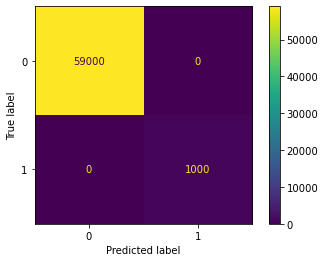

In [243]:
plot_confusion_matrix(gs3, X_train_imp_sc, y_train)

Our cross validation score in this instance in still significantly lower than previous cross validation scores.

## Evaluation

It seems most of our cross validation scores pale in comparison to our original simple Logistic Regression and our Decision Tree with tuned Hyperparameters. Let's run our test data through these two models to see which achieves a better result.

## Logistic Regression with Testing data

In [343]:
logreg

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2023)

In [344]:
y_preds_logreg_test = logreg.predict(X_test_imp_sc)

In [347]:
recall_score(y_train, y_preds_logreg)

0.959

In [345]:
recall_score(y_test, y_preds_logreg_test)

0.9466666666666667

In [346]:
cost_loss(y_test, y_preds_logreg_test)

13950

This is a fantastic result! It seems our Logistic Regression performs fantastically on unseen data, with a Recall Score of nearly 95%!

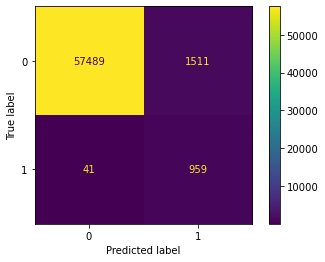

In [164]:
plot_confusion_matrix(logreg, X_train_imp_sc, y_train);

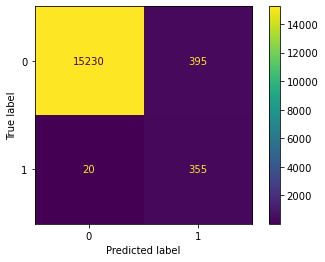

In [348]:
plot_confusion_matrix(logreg, X_test_imp_sc, y_test);

Although our model is still slightly overfit, our testing recall is only slightly lower than our training.

In [358]:
cost_loss(y_test, y_preds_logreg_test) / len(y_test)

0.871875

Implementing this model will cost \\$0.87 per vehicle for diagnosis, versus \\$8.33 with our Dummy Model, for a 90% cost reduction!

## Decision Tree with tuned hyperparameters

In [349]:
dt2

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=2023)

In [350]:
y_preds_dt2_test = dt2.predict(X_test_imp_sc)

In [236]:
recall_score(y_train, y_preds_dt2)

0.983

In [351]:
recall_score(y_test, y_preds_dt2_test)

0.9173333333333333

In [352]:
cost_loss(y_test, y_preds_dt2_test)

21190

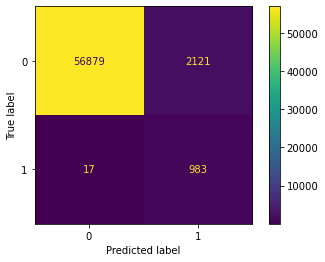

In [355]:
plot_confusion_matrix(dt2, X_train_imp_sc, y_train);

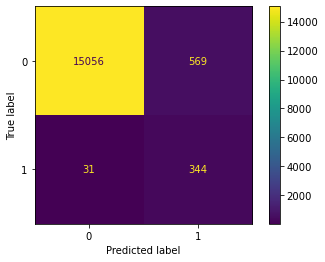

In [354]:
plot_confusion_matrix(dt2, X_test_imp_sc, y_test);

In [357]:
cost_loss(y_test, y_preds_dt2_test) / len(y_test)

1.324375

This Decision Tree does NOT perform as well as our Logistic Regression, therefore, our best and final model is actually the logreg which we started with!

## Conclusion

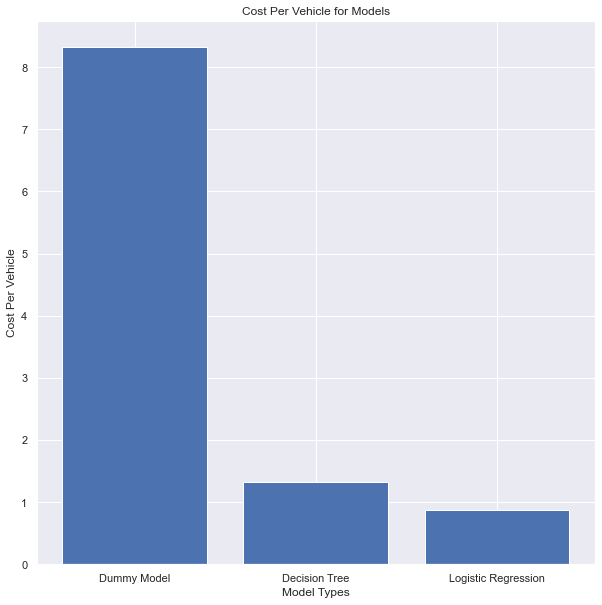

In [367]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_theme(style='darkgrid')
x_values = ['Dummy Model', 'Decision Tree', 'Logistic Regression']
y_values = [8.33, 1.32, 0.87]
ax.set_xlabel('Model Types')
ax.set_ylabel('Cost Per Vehicle')
ax.set_title('Cost Per Vehicle for Models')
plt.bar(x_values, y_values);

Our Logistic Regression model is the best at classifying unseen data, and as a result is the one which should be used in production. This model will be capable of saving the company 90% on the cost of APS diagnosis.